<img src="OC.png" width="50" height="50" align="left">    

***

<center> <font size="6"> <span style='color:Blue'> P7: Implémentez un modèle de scoring </span></font> </center>  

***

**Contexte**  
**Prêt à dépenser** est une société financière qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
<img src="pretadepenser.png" width="200" height="200">
**Mission**   
* Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
* Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
* Mettre en production le modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif qui appelle l’API pour les prédictions.

**Les données**  

* **application_{train|test}.csv**
C'est la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET). Données statiques pour toutes les demandes de prêt. Une ligne représente un prêt dans notre échantillon de données.

* **bureau.csv**
Tous les crédits précédents du client fournis par d'autres institutions financières qui ont été signalés au bureau de crédit (pour les clients ayant un prêt dans notre échantillon). Pour chaque prêt dans notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait au bureau de crédit avant la date de la demande.

* **bureau_balance.csv**
Soldes mensuels des crédits précédents au bureau de crédit. Cette table a une ligne pour chaque mois de l'historique de chaque crédit précédent signalé au bureau de crédit, c'est-à-dire que la table a (# de prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique observable des crédits précédents) lignes.

* **POS_CASH_balance.csv**
Instantanés mensuels des soldes des prêts précédents en espèces et en points de vente que le demandeur avait avec Home Credit. Cette table a une ligne pour chaque mois de l'historique de chaque crédit précédent chez Home Credit (crédits à la consommation et prêts en espèces) lié aux prêts dans notre échantillon, c'est-à-dire que la table a (# de prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique observable des crédits précédents) lignes.

* **redit_card_balance.csv**
Instantanés mensuels des soldes des cartes de crédit précédentes que le demandeur avait avec Home Credit. Cette table a une ligne pour chaque mois de l'historique de chaque crédit précédent chez Home Credit (crédits à la consommation et prêts en espèces) lié aux prêts dans notre échantillon, c'est-à-dire que la table a (# de prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable des cartes de crédit précédentes) lignes.

* **previous_application.csv**
Toutes les demandes précédentes de prêts Home Credit des clients ayant des prêts dans notre échantillon. Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

* **installments_payments.csv**
Historique des remboursements pour les crédits précédemment versés chez Home Credit liés aux prêts dans notre échantillon. Il y a a) une ligne pour chaque paiement effectué et b) une ligne pour chaque paiement manqué. Une ligne équivaut à un paiement d'une tranche ou une tranche correspondant à un paiement d'un crédit précédent Home Credit lié aux prêts dans notre échantillon.

* **HomeCredit_columns_description.csv**
Ce fichier contient des descriptions pour les colonnes dans les différents fichiers de données.

<img src="DB.png" width="800" height="800">

# Importation des données et des librairies Python pour DS

In [66]:
# ------------------------------------------
# Projet : Implémenter un modèle de scoring
# Données: https://www.kaggle.com/c/home-credit-default-risk/data
# Auteur : Rim BAHROUN
# Date: Avril 2023
# OpenClassrooms
# -------------------------------------------
# importation des librairies Python pour DS
# -------------------------------------------
import os
import csv
import numpy as np
import pandas as pd
import re
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'BAHROUN_Rim_1_notebook_042023.ipynb',
 'data',
 'DB.png',
 'env_python',
 'lightgbm_with_simple_features.py',
 'OC.png',
 'patch.diff',
 'pretadepenser.png',
 'README.md',
 '__pycache__']

In [3]:
# import lightgbm_with_simple_features

# Fonctions utiles

In [4]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [5]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns
                           if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns
                   if c not in original_columns]
    return df, new_columns

In [6]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows=None, nan_as_category=False):
    # Read data and merge
    df = pd.read_csv('data/source/application_train.csv', nrows=num_rows)
    test_df = pd.read_csv('data/source/application_test.csv', nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df, test_df], ignore_index=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [7]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv('data/source/bureau.csv', nrows=num_rows)
    bb = pd.read_csv('data/source/bureau_balance.csv', nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [8]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('data/source/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [9]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('data/source/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('data/source/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('data/source/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# Préparation des données

La préparation des données et features engineering sont effectuées sur la base du kernel Kaggle https://www.kaggle.com/code/tunguz/xgb-simple-features

In [100]:
debug = False
num_rows = 10000 if debug else None
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()
# # Divide in training/validation and test data
# train_df = df[df['TARGET'].notnull()]
# test_df = df[df['TARGET'].isnull()]
# print("Starting. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
# # del df
# gc.collect()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 30s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 31s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 16s
Installments payments df shape: (339587, 26)
Process installments payments - done in 35s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 16s


In [101]:
df.shape

(356251, 797)

In [102]:
df.isnull().sum()

SK_ID_CURR                               0
TARGET                               48744
CODE_GENDER                              0
FLAG_OWN_CAR                             0
FLAG_OWN_REALTY                          0
                                     ...  
CC_NAME_CONTRACT_STATUS_nan_MAX     252693
CC_NAME_CONTRACT_STATUS_nan_MEAN    252693
CC_NAME_CONTRACT_STATUS_nan_SUM     252693
CC_NAME_CONTRACT_STATUS_nan_VAR     253385
CC_COUNT                            252693
Length: 797, dtype: int64

In [103]:
df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
df.TARGET.value_counts(dropna=False)

0.0    282682
NaN     48744
1.0     24825
Name: TARGET, dtype: int64

In [108]:
df.to_csv("data/traited/df_credit.csv")

In [109]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

In [110]:
train_df.to_csv("data/traited/df_credit_train.csv")

In [111]:
test_df.to_csv("data/traited/df_credit_test.csv")

# Modèle

In [98]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            #nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1, )

        clf.fit(train_x, train_y,
                eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc',
                callbacks=[lgb.callback.early_stopping(stopping_rounds=200),
                           lgb.callback.log_evaluation(200)])

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.4f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])), sep='')
        print("\n")
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.4f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

Starting LightGBM. Train shape: (10000, 767), test shape: (10000, 767)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.844837	training's binary_logloss: 0.211008	valid_1's auc: 0.761639	valid_1's binary_logloss: 0.265962
[400]	training's auc: 0.88292	training's binary_logloss: 0.192999	valid_1's auc: 0.762533	valid_1's binary_logloss: 0.264988
Early stopping, best iteration is:
[346]	training's auc: 0.874052	training's binary_logloss: 0.19723	valid_1's auc: 0.765036	valid_1's binary_logloss: 0.264362
Fold  1 AUC : 0.7650


Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.844117	training's binary_logloss: 0.217027	valid_1's auc: 0.81325	valid_1's binary_logloss: 0.201522
Early stopping, best iteration is:
[117]	training's auc: 0.8214	training's binary_logloss: 0.228799	valid_1's auc: 0.817679	valid_1's binary_logloss: 0.203521
Fold  2 AUC : 0.8177


Training until validation scores don't improve for 200 rounds
[2

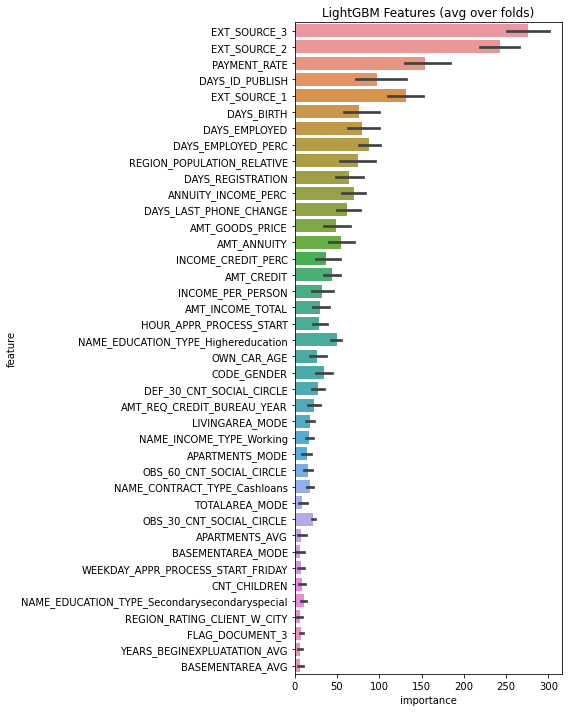

In [99]:
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds=10, stratified=False, debug=debug)